In [1]:
!pip install sentence-transformers
!pip install pandas scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# ----------------------------
# SECTION 1: Imports & Setup
# ----------------------------

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import umap
import re
import joblib
from sentence_transformers import SentenceTransformer, util


# ----------------------------
# SECTION 2: Data Loading
# ----------------------------

Aperçu du dataset :


,Nom,DCI,Classe,Indications,Dosage
0,5-FLUOROURACIL,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,250 MG
1,5-FLUOROURACILE EBEWE,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,1000 mg/20 ml
2,5-FLUOROURACILE EBEWE,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,500 mg/10 ml


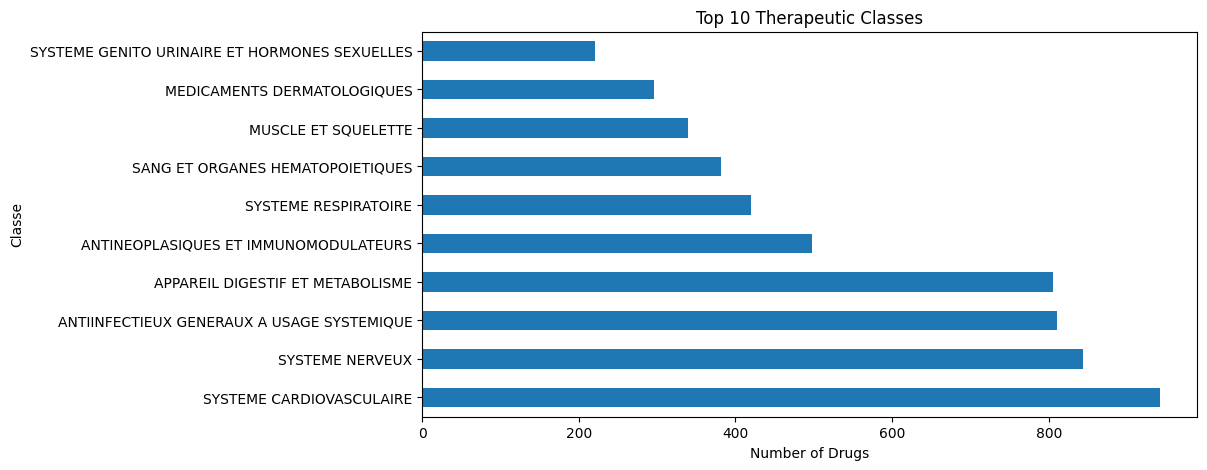

In [3]:
# Load your CSV file
df = pd.read_csv("liste_amm.csv")

# Show a preview
print("Dataset preview:")
display(df[['Nom', 'DCI', 'Classe', 'Indications', 'Dosage']].head(3))

# Plotting the top 10 therapeutic classes
plt.figure(figsize=(10, 5))
df['Classe'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Therapeutic Classes')
plt.xlabel('Number of Drugs')
plt.show()



In [8]:
df.head()

,Nom,Dosage,Forme,Présentation,DCI,Classe,Sous Classe,Laboratoire,AMM,Date AMM,Conditionnement primaire,Spécifocation Conditionnement primaire,tableau,Durée de conservation,Indications,G/P/B,VEIC,Dose_mg,Biologic,Admin_Route
0,5-FLUOROURACIL,250 MG,Solution injectable,B/5/5ML,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943091H,2001-01-20,Ampoule,en verre,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital,250.0,False,Intraveineux (IV)
1,5-FLUOROURACILE EBEWE,1000 mg/20 ml,Solution injectable pour perfusion,B/1/20 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943093H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital,1000.0,False,Inconnue
2,5-FLUOROURACILE EBEWE,500 mg/10 ml,Solution injectable pour perfusion,B/5/10 ml,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,EBEWE Pharma,6943092H,2012-04-30,Flacon,en verre incolore de type I + bouchon bromobut...,A,24,- Adénocarcinomes digestifs évolués;\r- Cancer...,Générique,Vital,500.0,False,Inconnue
3,ABBOTICINE,200 MG,Poudre pour suspension orale,FL/60ML,ERYTHROMYCINE,ANTIINFECTIEUX GENERAUX A USAGE SYSTEMIQUE,ANTIBACTERIENS (USAGE SYSTEMIQUE),ADWYA,9043061,1990-12-19,Flacon,en verre ambre,A,48,INFECTIONS DUES AUX GERMES SENSIBLES NOTAMMENT...,Princeps,Essentiel,200.0,False,Inconnue
4,ABEVMY,400 mg(25mg/ml),Solution à diluer pour perfusion,B/1FL/16ml,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,ANTINEOPLASIQUES,MYLAN PHARMACEUTICALS PRIVATE LIMITED,20343022H,2021-09-06,Flacon,en verrede type I,A,24,Cancer métastatique du colon ou du rectum\r- A...,Biosimilaire,Vital,400.0,False,Inconnue


# ----------------------------
# SECTION 3: Feature Engineering
# ----------------------------

In [4]:
print("\nEngineering features...")

# --- 1. Extracting the dose ---
def extract_dose(dosage):
    if isinstance(dosage, str):
        match = re.search(r'(\d+(?:\.\d+)?)\s*mg', dosage, re.IGNORECASE)
        return float(match.group(1)) if match else np.nan
    return np.nan

df['Dose_mg'] = df['Dosage'].apply(extract_dose)

# --- 2. Detecting biological drugs ---
BIOLOGIC_KEYWORDS = r'\b(MAB|ZUMA|CEPT|CPT|KIN)\b'
df['Biologic'] = df['DCI'].fillna('').str.contains(BIOLOGIC_KEYWORDS, case=False, regex=True)

# --- 3. Normalizing the route of administration ---
ADMIN_ROUTE_MAPPING = {
    'SOLUTION INJECTABLE': 'Intravenous (IV)',
    'COMPRIMÉ': 'Oral',
    'GEL': 'Topical',
    'SIROP': 'Oral',
    'POMMADE': 'Topical',
    'POUDRE': 'Other',
    'CAPSULE': 'Oral'
}
df['Admin_Route'] = df['Forme'].str.upper().map(ADMIN_ROUTE_MAPPING).fillna('Unknown')



Engineering features...


<ipython-input-4-fdd9c3b28243>:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['Biologic'] = df['DCI'].fillna('').str.contains(BIOLOGIC_KEYWORDS, case=False, regex=True)


# ----------------------------
# SECTION 3.1: Smart NaN Imputation
# ----------------------------

In [5]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("\nImputing missing values in low-memory mode...")

def smart_fill_low_memory(df, target_column, text_columns):
    df_filled = df.copy()
    missing_idx = df[df[target_column].isna()].index

    # Create the text corpus
    corpus = df[text_columns].fillna('').agg(' '.join, axis=1)

    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    for idx in missing_idx:
        # Embedding of the drug with NaN
        tfidf_vector = tfidf_matrix[idx]

        # Compare only with drugs that have non-NaN target values
        valid_idx = df[df[target_column].notna()].index
        valid_vectors = tfidf_matrix[valid_idx]

        # Calculate similarity (lightweight: 1 against a few rows)
        similarities = cosine_similarity(tfidf_vector, valid_vectors).flatten()

        # Find the best match
        best_match_local_idx = similarities.argmax()
        best_match_idx = valid_idx[best_match_local_idx]

        if similarities[best_match_local_idx] > 0:
            df_filled.at[idx, target_column] = df.at[best_match_idx, target_column]
        else:
            df_filled.at[idx, target_column] = f"{target_column} unknown"

    return df_filled

# Columns to use for similarity
text_cols = ['Nom', 'Forme', 'Dosage']

# Smart imputation without memory explosion
df = smart_fill_low_memory(df, 'DCI', text_cols)
df = smart_fill_low_memory(df, 'Classe', text_cols)
df = smart_fill_low_memory(df, 'Indications', text_cols)

print("\nAfter smart filling (low-memory mode):")
display(df[['Nom', 'DCI', 'Classe', 'Indications']].sample(5))



Imputing missing values in low-memory mode...

After smart filling (low memory mode):


,Nom,DCI,Classe,Indications
3658,MUXOL,AMBROXOL,SYSTEME RESPIRATOIRE,Traitement des troubles de la sécrétion bronch...
2341,FLOXAMED,NORFLOXACINE,ORGANES SENSORIELS,Traitement antibactérien local des infections ...
2288,FENOLIP,FENOFIBRATE,SYSTEME CARDIOVASCULAIRE,FENOLIP est indiqué en complément d'un régime ...
1716,DIABITOS,METFORMINE,APPAREIL DIGESTIF ET METABOLISME,"Traitement du diabète de type 2, en particulie..."
2435,FUMIDEX,ACIDE FUSIDIQUE,MEDICAMENTS DERMATOLOGIQUES,Infections de la peau dues à staphylocoque et ...


In [6]:

print("\nSample of engineered data:")
display(df[['Nom', 'DCI', 'Classe', 'Indications', 'Dose_mg', 'Admin_Route', 'Biologic']].head())


Sample of engineered data:


,Nom,DCI,Classe,Indications,Dose_mg,Admin_Route,Biologic
0,5-FLUOROURACIL,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,250.0,Intraveineux (IV),False
1,5-FLUOROURACILE EBEWE,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,1000.0,Inconnue,False
2,5-FLUOROURACILE EBEWE,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,- Adénocarcinomes digestifs évolués;\r- Cancer...,500.0,Inconnue,False
3,ABBOTICINE,ERYTHROMYCINE,ANTIINFECTIEUX GENERAUX A USAGE SYSTEMIQUE,INFECTIONS DUES AUX GERMES SENSIBLES NOTAMMENT...,200.0,Inconnue,False
4,ABEVMY,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,Cancer métastatique du colon ou du rectum\r- A...,400.0,Inconnue,False



Visualizing features...


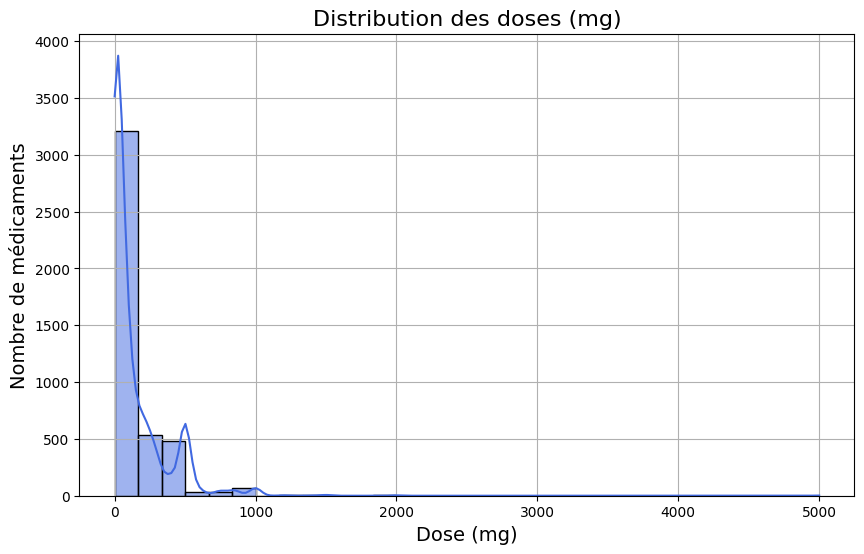

<ipython-input-7-b04f0c84b984>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Admin_Route', order=admin_order, palette='Set2')


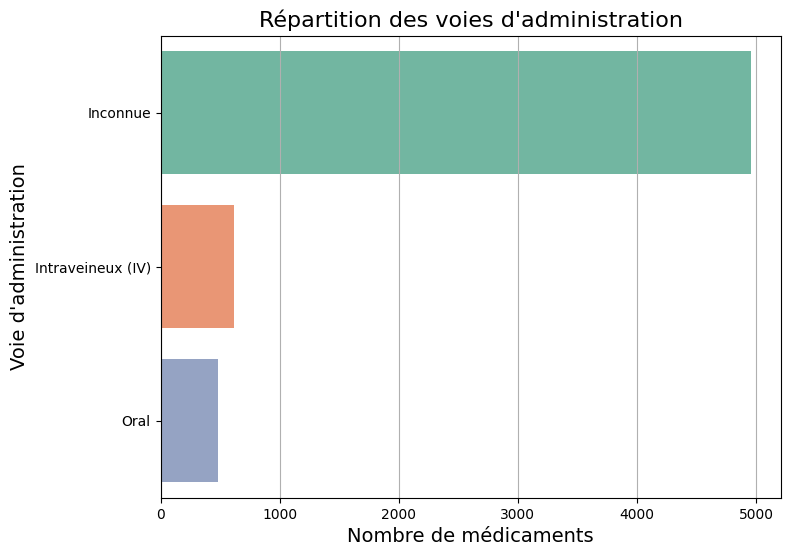

<ipython-input-7-b04f0c84b984>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette="coolwarm")


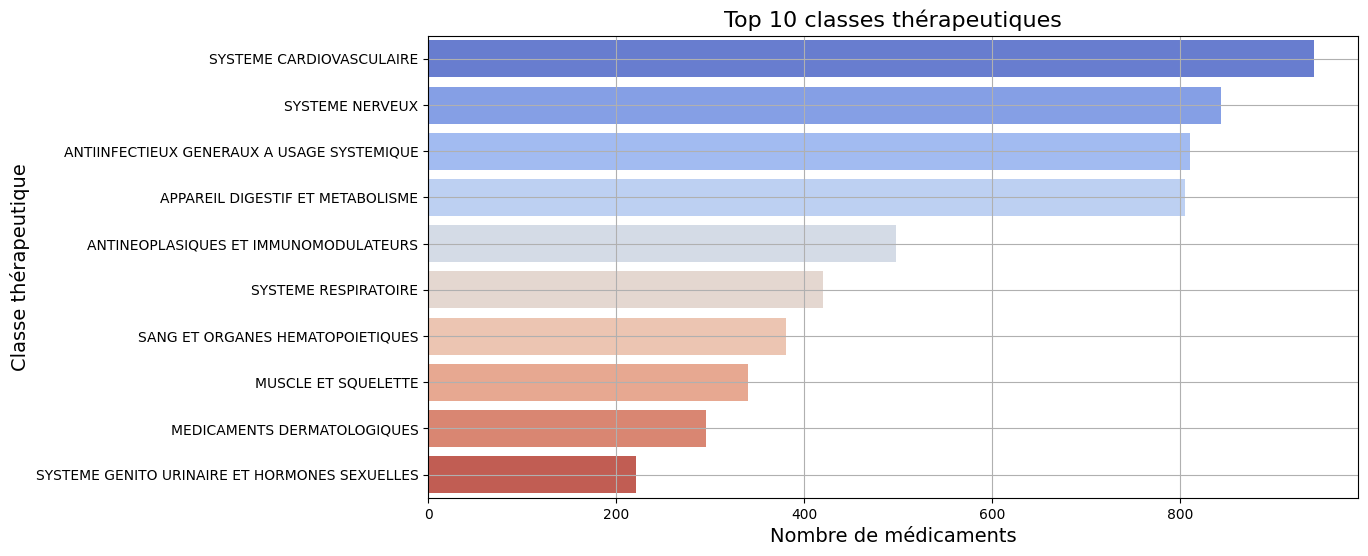

In [7]:
# ----------------------------
# SECTION 3bis: Enhanced Visualization
# ----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

print("\nVisualizing features...")

# --- 1. Distribution of doses ---
plt.figure(figsize=(10, 6))
sns.histplot(df['Dose_mg'].dropna(), bins=30, kde=True, color="royalblue")
plt.title('Distribution of doses (mg)', fontsize=16)
plt.xlabel('Dose (mg)', fontsize=14)
plt.ylabel('Number of drugs', fontsize=14)
plt.grid(True)
plt.show()

# --- 2. Distribution of administration routes ---
plt.figure(figsize=(8, 6))
admin_order = df['Admin_Route'].value_counts().index
sns.countplot(data=df, y='Admin_Route', order=admin_order, palette='Set2')
plt.title('Distribution of administration routes', fontsize=16)
plt.xlabel('Number of drugs', fontsize=14)
plt.ylabel('Administration route', fontsize=14)
plt.grid(axis='x')
plt.show()

# --- 3. Top therapeutic classes ---
plt.figure(figsize=(12, 6))
top_classes = df['Classe'].value_counts().head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, palette="coolwarm")
plt.title('Top 10 therapeutic classes', fontsize=16)
plt.xlabel('Number of drugs', fontsize=14)
plt.ylabel('Therapeutic class', fontsize=14)
plt.grid(True)
plt.show()


In [11]:
print("\nGenerating embeddings with Sentence-BERT...")

!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

class DrugEncoder:
    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    def encode(self, texts):
        return self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)

# Preparing the drug profiles
# We build a text profile by combining all the useful columns

# Replace NaN with empty strings to avoid concatenation problems
df['Drug_Profile'] = (
    df['DCI'].fillna('') + " " +
    df['Classe'].fillna('') + " " +
    df['Sous Classe'].fillna('') + " " +
    df['Indications'].fillna('') + " " +
    df['Dosage'].fillna('') + " " +
    df['Biologic'].fillna('').astype(str) + " " +
    df['G/P/B'].fillna('') + " " +
    df['VEIC'].fillna('') + " " +
    df['Forme'].fillna('')
)

# Encoding the drug profiles
encoder = DrugEncoder()
embeddings = encoder.encode(df['Drug_Profile'].tolist())

print(f"Embeddings generated with shape: {embeddings.shape}")




Génération des embeddings avec Sentence-BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings générés avec shape: (6059, 384)


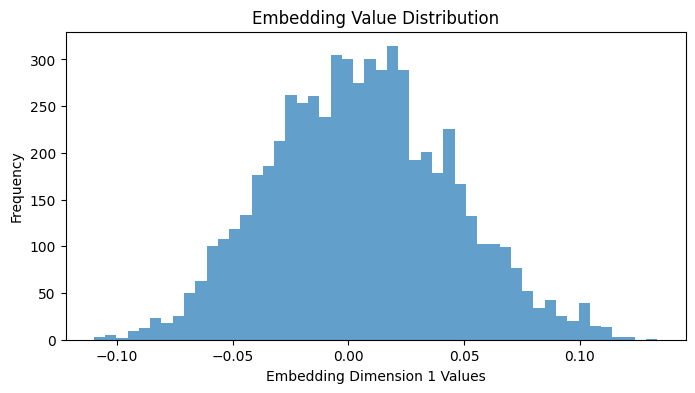

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(embeddings[:, 0], bins=50, alpha=0.7)
plt.title('Embedding Value Distribution')
plt.xlabel('Embedding Dimension 1 Values')
plt.ylabel('Frequency')
plt.show()


Visualisation des embeddings avec UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


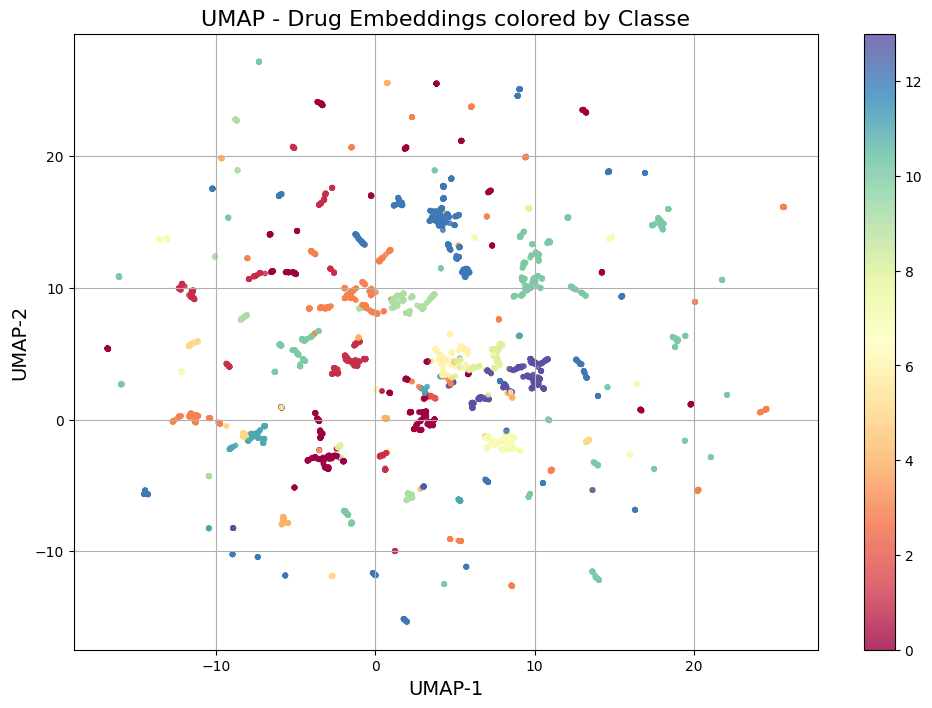

In [16]:
# ----------------------------
# SECTION 9: Clustering Visualization with UMAP
# ----------------------------

print("\nVisualisation des embeddings avec UMAP...")

import umap
import matplotlib.pyplot as plt

def plot_umap(embeddings, labels, title="UMAP of Drug Embeddings"):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=labels, cmap='Spectral', s=10, alpha=0.8
    )
    plt.colorbar(scatter)
    plt.title(title, fontsize=16)
    plt.xlabel('UMAP-1', fontsize=14)
    plt.ylabel('UMAP-2', fontsize=14)
    plt.grid(True)
    plt.show()

# Exemple: colorier selon la "Classe thérapeutique"
# Attention: pour avoir des couleurs il faut encoder les classes en nombres
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
classe_labels = le.fit_transform(df['Classe'].astype(str))

plot_umap(embeddings, classe_labels, title="UMAP - Drug Embeddings colored by Classe")


# ----------------------------
# SECTION 5: Drug Recommendation System
# ----------------------------

In [13]:
def generate_clinical_comment(ref_row, alt_row):
    """
    Generates a clinical comment based on the comparison of form and dose
    between the reference drug and the proposed alternative.

    Args:
        ref_row (pd.Series): Reference row (base drug)
        alt_row (pd.Series): Alternative row

    Returns:
        str: Clinical comment
    """
    comments = []

    # Form Check
    if ref_row['Forme'] != alt_row['Forme']:
        comments.append(f"⚠️ Different form: {alt_row['Forme']} vs {ref_row['Forme']}.")

    else:
        comments.append(f"✅ Same form: {alt_row['Forme']}.")

    # Dose Check
    if pd.isna(ref_row['Dose_mg']) or pd.isna(alt_row['Dose_mg']):
        comments.append("ℹ️ Missing dose for comparison.")
    else:
        dose_ratio = alt_row['Dose_mg'] / ref_row['Dose_mg']
        if 0.8 <= dose_ratio <= 1.2:
            comments.append("✅ Equivalent or close dose.")
        elif dose_ratio < 0.8:
            comments.append(f"⚠️ Lower dose ({alt_row['Dose_mg']} mg vs {ref_row['Dose_mg']} mg), adjustment needed.")
        else:
            comments.append(f"⚠️ Higher dose ({alt_row['Dose_mg']} mg vs {ref_row['Dose_mg']} mg), adjustment needed.")

    # Final result
    return " ".join(comments)



In [14]:
# ---------------------------------------------------------------
# UPDATE TO THE RECOMMENDER CLASS
# ---------------------------------------------------------------

print("\nUpdating the recommendation engine...")

from sentence_transformers.util import cos_sim

class DrugRecommender:
    def __init__(self, embeddings, df):
        self.embeddings = embeddings
        self.df = df
        self.drug_names = df['Nom']

    def recommend(self, drug_name, top_n=5):
        # Normalize the input drug name
        drug_name_normalized = drug_name.strip().upper()

        matches = self.drug_names.str.strip().str.upper() == drug_name_normalized
        idx = np.where(matches)[0]

        if idx.size == 0:
            print(f"Warning: '{drug_name}' not found in the dataset.")
            return pd.DataFrame()

        idx = idx[0]  # first matching index

        similarities = cos_sim([self.embeddings[idx]], self.embeddings)[0].cpu().numpy()

        valid_indices = np.argsort(-similarities)[1:top_n+1]
        results = self.df.iloc[valid_indices].copy()
        results['Similarity'] = similarities[valid_indices]

        # Generate the clinical comment
        ref_row = self.df.iloc[idx]
        results['Clinical Comment'] = results.apply(lambda row: generate_clinical_comment(ref_row, row), axis=1)

        return results[['Nom', 'DCI', 'Classe', 'Dose_mg', 'Indications', 'Similarity', 'Clinical Comment']]



Mise à jour du moteur de recommandation...


In [15]:
recommender = DrugRecommender(embeddings, df)
sample_recommendations = recommender.recommend("ABEVMY", top_n=5)

if not sample_recommendations.empty:
    print("\nSample recommendations:")
    display(sample_recommendations)



Exemple de recommandations:


/usr/local/lib/python3.11/dist-packages/sentence_transformers/util.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  a = torch.tensor(a)


,Nom,DCI,Classe,Dose_mg,Indications,Similarity
5,ABEVMY,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,100.0,Cancer métastatique du colon ou du rectum\r- A...,0.999783
615,AVASTIN,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,400.0,1- Cancer métastatique du colon ou du rectum\r...,0.970349
616,AVASTIN,BEVACIZUMAB,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,100.0,1- Cancer métastatique du colon ou du rectum\r...,0.970285
1525,CYTOFLU,FLUOROURACILE,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,500.0,le fluorouracile 50mg/mL est indiqué dans:\r- ...,0.702565
915,CAMPTO,IRINOTECAN,ANTINEOPLASIQUES ET IMMUNOMODULATEURS,20.0,CAMPT O est indiqué dans le traitement des can...,0.693133


# ----------------------------
# SECTION 6: Save the model
# ----------------------------

In [ ]:
print("\nSaving the recommendation model...")
joblib.dump(recommender, 'drug_recommender.pkl')
print("Model saved as 'drug_recommender.pkl'")


Saving the recommendation model...
Model saved as 'drug_recommender.pkl'
